# Imports

In [1]:
!pip install pandas seaborn matplotlib nltk scikit-learn

# Cargar base de datos

In [21]:
import json
import os
from pathlib import Path

# 1. Crear directorios necesarios
Path("data/raw").mkdir(parents=True, exist_ok=True)

# 2. Cargar tu archivo subido
input_file = "../dataset_final.json" 
output_file = "all_data_cleaned_final.json" # Nombre que exige tu script

print(f"🔄 Procesando {input_file}...")

try:
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    formatted_data = []
    stats = {"latam": 0, "europe": 0, "unknown": 0}
    
    # Países de Latam para mapeo automático si falta la región
    paises_latam = ['chile', 'colombia', 'peru', 'argentina', 'mexico', 'bolivia', 'ecuador', 'uruguay']
    
    for item in data:
        # Normalizar región
        region = item.get('region', '').lower()
        country = item.get('country', '').lower()
        
        # Lógica de corrección de región
        if 'europe' in region or 'griega' in country or 'nordica' in country or 'nórdica' in country:
            final_region = 'europe'
        elif 'latam' in region or 'latin' in region or country in paises_latam:
            final_region = 'latam'
        else:
            final_region = 'unknown' # No debería pasar con tus datos limpios
            
        # Actualizar item
        item['region'] = final_region
        
        # Validación mínima para evitar errores en el script principal
        if 'prompt' not in item: item['prompt'] = ""
        if 'target_new' not in item: item['target_new'] = ""
        if 'relation' not in item: item['relation'] = "unknown"
        if 'subject' not in item: item['subject'] = "unknown"

        if final_region != 'unknown':
            formatted_data.append(item)
            stats[final_region] += 1
            
    # Guardar en la ubicación correcta
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(formatted_data, f, ensure_ascii=False, indent=2)
        
    print(f"✅ ¡Listo! Dataset guardado en: {output_file}")
    print(f"📊 Resumen de datos preparados:")
    print(f"   - Latam: {stats['latam']}")
    print(f"   - Europa: {stats['europe']}")
    print(f"   - Total: {len(formatted_data)}")

except FileNotFoundError:
    print(f"❌ Error: No encuentro '{input_file}'. Asegúrate de haberlo subido a Colab.")

🔄 Procesando ../dataset_final.json...
✅ ¡Listo! Dataset guardado en: all_data_cleaned_final.json
📊 Resumen de datos preparados:
   - Latam: 7345
   - Europa: 2183
   - Total: 9528


In [28]:
import json
import os
import pandas as pd  # <--- NUEVO: Necesario para leer el CSV
from pathlib import Path

# 1. Configuración de archivos
input_json = "../dataset_final.json"   # Tu archivo JSON actual
input_csv = "../tripletas_consolidadas.csv" # El CSV con la verdad (sujeto, relación, objeto)
output_file = "all_data_cleaned_final2.json"

# Crear directorios si no existen
Path("data/raw").mkdir(parents=True, exist_ok=True)

print(f"🔄 Cargando CSV de referencia: {input_csv}...")

try:
    # A. CARGAR EL CSV (LA FUENTE DE VERDAD)
    # Rellenamos nulos con string vacío para evitar errores en JSON
    df_ref = pd.read_csv(input_csv).fillna('')
    print(f"   ✓ CSV cargado con {len(df_ref)} filas.")

    print(f"🔄 Procesando JSON: {input_json}...")
    with open(input_json, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    formatted_data = []
    stats = {"latam": 0, "europe": 0, "unknown": 0}
    found_in_csv = 0
    
    # Países de Latam para mapeo automático
    paises_latam = ['chile', 'colombia', 'peru', 'argentina', 'mexico', 'bolivia', 'ecuador', 'uruguay']
    
    for item in data:
        # --- 1. LÓGICA DE REGIÓN (Tu código original) ---
        region = item.get('region', '').lower()
        country = item.get('country', '').lower()
        
        if 'europe' in region or 'griega' in country or 'nordica' in country or 'nórdica' in country:
            final_region = 'europe'
        elif 'latam' in region or 'latin' in region or country in paises_latam:
            final_region = 'latam'
        else:
            final_region = 'unknown'
            
        item['region'] = final_region
        
        # --- 2. INYECCIÓN DE DATOS DESDE EL CSV (NUEVO) ---
        # Usamos el 'index' del JSON para buscar la fila en el CSV
        idx = item.get('index')
        
        # Verificamos que idx exista, sea entero y esté dentro del rango del CSV
        if idx is not None and isinstance(idx, int) and 0 <= idx < len(df_ref):
            row = df_ref.iloc[idx]
            
            # Asignamos los valores del CSV al JSON
            item['subject'] = str(row['entidad']).strip()      # Asigna Sujeto
            item['relation'] = str(row['relacion']).strip()    # Asigna Relación
            item['target_true'] = str(row['objeto']).strip()   # Asigna Original Target
            
            # Opcional: También puedes corregir el país si el CSV es más confiable
            if not item.get('country'):
                item['country'] = str(row['pais']).strip()
                
            found_in_csv += 1
        else:
            # Si no hay match en el CSV, aseguramos valores por defecto para no romper el código
            if 'subject' not in item: item['subject'] = "unknown"
            if 'relation' not in item: item['relation'] = "unknown"
            if 'target_true' not in item: item['target_true'] = ""

        # --- 3. LIMPIEZA FINAL ---
        if 'prompt' not in item: item['prompt'] = ""
        if 'target_new' not in item: item['target_new'] = ""

        if final_region != 'unknown':
            formatted_data.append(item)
            stats[final_region] += 1
            
    # Guardar resultado
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(formatted_data, f, ensure_ascii=False, indent=2)
        
    print(f"✅ ¡Listo! Dataset guardado en: {output_file}")
    print(f"📊 Resumen:")
    print(f"   - Total procesado: {len(formatted_data)}")
    print(f"   - Encontrados en CSV: {found_in_csv} (Filas enriquecidas)")
    print(f"   - Latam: {stats['latam']}")
    print(f"   - Europa: {stats['europe']}")

except FileNotFoundError as e:
    print(f"❌ Error: Archivo no encontrado. {e}")
except Exception as e:
    print(f"❌ Error inesperado: {e}")

🔄 Cargando CSV de referencia: ../tripletas_consolidadas.csv...
   ✓ CSV cargado con 9528 filas.
🔄 Procesando JSON: ../dataset_final.json...
✅ ¡Listo! Dataset guardado en: all_data_cleaned_final2.json
📊 Resumen:
   - Total procesado: 9528
   - Encontrados en CSV: 0 (Filas enriquecidas)
   - Latam: 7345
   - Europa: 2183


In [29]:
import json
import pandas as pd
from pathlib import Path

# --- CONFIGURACIÓN ---
input_json = "../dataset_final.json"          # Tu JSON con los prompts
input_csv = "../tripletas_consolidadas.csv"   # Tu CSV con las relaciones reales
output_file = "all_data_merged.json"

# Crear carpeta de salida
Path("data/raw").mkdir(parents=True, exist_ok=True)

print(f"🔄 Cargando datos...")

# 1. Cargar CSV y normalizar para facilitar la búsqueda
# Convertimos a string y minúsculas para comparar sin errores
df = pd.read_csv(input_csv).fillna('')
df['key_match'] = df['objeto'].astype(str).str.strip().str.lower()
df['pais_match'] = df['pais'].astype(str).str.strip().str.lower()

print(f"   ✓ CSV cargado: {len(df)} tripletas de referencia.")

# 2. Cargar JSON
with open(input_json, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"   ✓ JSON cargado: {len(data)} prompts.")

merged_data = []
matches_found = 0
matches_failed = 0

# Países Latam para asignar región si falta
paises_latam = ['chile', 'colombia', 'peru', 'argentina', 'mexico', 'bolivia', 'ecuador', 'uruguay']

print("\n🚀 Iniciando cruce de datos...")

for item in data:
    # --- A. PREPARAR CLAVES DE BÚSQUEDA ---
    target_buscar = str(item.get('target_new', '')).strip().lower()
    pais_buscar = str(item.get('country', '')).strip().lower()
    
    # --- B. BUSCAR EN EL CSV (MAGIA AQUÍ) ---
    # Filtramos el DataFrame buscando donde coincida el Objeto y el País
    match = df[
        (df['key_match'] == target_buscar) & 
        (df['pais_match'] == pais_buscar)
    ]
    
    if not match.empty:
        # ¡ENCONTRAMOS LA TRIPLETA ORIGINAL!
        # Tomamos la primera coincidencia (normalmente es única)
        row = match.iloc[0]
        
        # Asignamos los datos que faltaban
        item['subject'] = str(row['entidad']).strip()
        item['relation'] = str(row['relacion']).strip()
        item['target_true'] = str(row['objeto']).strip()
        
        # Corrección opcional: si el prompt tiene el sujeto en mayúscula y el CSV en minúscula,
        # intentamos respetar el formato del CSV pero verificamos luego.
        
        matches_found += 1
    else:
        # Si no encontramos coincidencia exacta, marcamos como unknown
        item['subject'] = "unknown"
        item['relation'] = "unknown"
        item['target_true'] = item.get('target_new', '') # Fallback
        matches_failed += 1

    # --- C. NORMALIZAR REGIÓN (Tu lógica anterior) ---
    region = item.get('region', '').lower()
    country = item.get('country', '').lower()
    
    if 'europe' in region or 'griega' in country or 'nordica' in country or 'nórdica' in country:
        final_region = 'europe'
    elif 'latam' in region or 'latin' in region or country in paises_latam:
        final_region = 'latam'
    else:
        final_region = 'unknown'
    
    item['region'] = final_region
    
    # --- D. VALIDACIÓN FINAL PARA ROME ---
    # ROME fallará si el 'subject' no está textualmente dentro del 'prompt'.
    # Intentamos arreglarlo si es solo diferencia de mayúsculas/minúsculas.
    subj = item['subject']
    prompt = item.get('prompt', '')
    
    if subj != "unknown" and prompt:
        if subj not in prompt:
            # Intento 1: ¿Está en el prompt pero con otra capitalización?
            import re
            match_case = re.search(re.escape(subj), prompt, re.IGNORECASE)
            if match_case:
                # Actualizamos el subject para que sea IDÉNTICO al del prompt
                item['subject'] = match_case.group(0)
            else:
                # Si de verdad no está (ej: Prompt "El mito local...", Subject "Argentina")
                # ROME va a fallar. Podríamos marcarlo.
                pass 

    merged_data.append(item)

# Guardar
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(merged_data, f, ensure_ascii=False, indent=2)

print("\n" + "="*50)
print(f"✅ PROCESO COMPLETADO")
print("="*50)
print(f"📂 Archivo generado: {output_file}")
print(f"📊 Estadísticas de Cruce:")
print(f"   - Match Exitoso (Datos del CSV inyectados): {matches_found}")
print(f"   - Sin Match (Se quedaron como 'unknown'): {matches_failed}")
print(f"   - Total Filas: {len(merged_data)}")

if matches_failed > 0:
    print("\n⚠️  ADVERTENCIA: Hubo elementos que no se encontraron en el CSV.")
    print("    Posibles causas: Errores de tipeo en 'target_new' o diferencias de encoding.")

🔄 Cargando datos...
   ✓ CSV cargado: 9528 tripletas de referencia.
   ✓ JSON cargado: 9528 prompts.

🚀 Iniciando cruce de datos...

✅ PROCESO COMPLETADO
📂 Archivo generado: all_data_merged.json
📊 Estadísticas de Cruce:
   - Match Exitoso (Datos del CSV inyectados): 9528
   - Sin Match (Se quedaron como 'unknown'): 0
   - Total Filas: 9528


# Exploracion y estadisticas descriptivas del dataset

In [30]:
"""
Script 1: Exploración y estadísticas descriptivas del dataset
VERSIÓN 2 REGIONES: Latam vs. Europa
"""

import json
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from utils import Config, load_json, save_json, log_decision

# Configurar
Config.setup_directories()
sns.set_style('whitegrid')


def count_tokens(text: str, tokenizer) -> int:
    """Contar tokens de un texto"""
    return len(tokenizer.encode(text, add_special_tokens=True))


def analyze_dataset(data: list, tokenizer) -> dict:
    """Análisis completo de un dataset"""
    
    stats = {
        'n_total': len(data),
        'regions': Counter(),
        'relations': Counter(),
        'entities': set(),
        'prompt_lengths': [],
        'target_lengths': [],
        'examples_by_region': defaultdict(list)
    }
    
    for item in data:
        region = item.get('region', item.get('country', 'unknown'))
        stats['regions'][region] += 1
        stats['relations'][item.get('relation', 'unknown')] += 1
        stats['entities'].add(item.get('subject', ''))
        
        # Longitudes
        prompt_len = count_tokens(item['prompt'], tokenizer)
        target_len = count_tokens(item['target_new'], tokenizer)
        stats['prompt_lengths'].append(prompt_len)
        stats['target_lengths'].append(target_len)
        
        # Guardar por región
        stats['examples_by_region'][region].append(item)
    
    stats['n_unique_entities'] = len(stats['entities'])
    stats['entities'] = None  # Liberar memoria
    
    return stats


def create_summary_table(data: list, stats: dict, tokenizer) -> pd.DataFrame:
    """Crear tabla resumen por región"""
    
    rows = []
    
    # Crear un mapeo de índices por región
    data_by_region = {}
    for i, item in enumerate(data):
        region = item.get('region', item.get('country', 'unknown'))
        if region not in data_by_region:
            data_by_region[region] = []
        data_by_region[region].append(i)
    
    # Crear la tabla
    for region, count in stats['regions'].items():
        region_indices = data_by_region.get(region, [])
        
        if len(region_indices) == 0:
            continue
        
        region_prompts = [stats['prompt_lengths'][i] for i in region_indices]
        region_targets = [stats['target_lengths'][i] for i in region_indices]
        
        # Usar el nombre legible de la región
        region_name = Config.REGION_NAMES.get(region, region)
        
        rows.append({
            'Region': region_name,
            'N_ejemplos': count,
            'Promedio_tokens_prompt': f"{np.mean(region_prompts):.1f}",
            'Std_tokens_prompt': f"{np.std(region_prompts):.1f}",
            'Promedio_tokens_target': f"{np.mean(region_targets):.1f}",
            'Std_tokens_target': f"{np.std(region_targets):.1f}"
        })
    
    return pd.DataFrame(rows)


def plot_distributions(stats: dict, output_dir: Path):
    """Crear visualizaciones"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Subplot 1: Conteo de ejemplos por región
    regions = [Config.REGION_NAMES.get(r, r) for r in stats['regions'].keys()]
    counts = list(stats['regions'].values())
    colors = ['#3498db', '#e74c3c']  # Azul para Latam, Rojo para Europa
    
    axes[0, 0].barh(regions, counts, color=colors)
    axes[0, 0].set_xlabel('N° de ejemplos')
    axes[0, 0].set_title('Distribución por Región')
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # Agregar valores en las barras
    for i, (region, count) in enumerate(zip(regions, counts)):
        axes[0, 0].text(count, i, f' {count}', va='center')
    
    # Subplot 2: Top 10 relaciones
    top_relations = stats['relations'].most_common(10)
    rel_names = [r[0] for r in top_relations]
    rel_counts = [r[1] for r in top_relations]
    axes[0, 1].barh(rel_names, rel_counts, color='coral')
    axes[0, 1].set_xlabel('N° de ejemplos')
    axes[0, 1].set_title('Top 10 Tipos de Relación')
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # Subplot 3: Distribución de longitud de prompts
    axes[1, 0].hist(stats['prompt_lengths'], bins=30, 
                     color='mediumseagreen', edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Longitud (tokens)')
    axes[1, 0].set_ylabel('Frecuencia')
    axes[1, 0].set_title('Distribución de Longitud de Prompts')
    axes[1, 0].axvline(np.mean(stats['prompt_lengths']), 
                       color='red', linestyle='--', linewidth=2, label='Media')
    axes[1, 0].legend()
    
    # Subplot 4: Distribución de longitud de targets
    axes[1, 1].hist(stats['target_lengths'], bins=20, 
                     color='mediumpurple', edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Longitud (tokens)')
    axes[1, 1].set_ylabel('Frecuencia')
    axes[1, 1].set_title('Distribución de Longitud de Targets')
    axes[1, 1].axvline(np.mean(stats['target_lengths']), 
                       color='red', linestyle='--', linewidth=2, label='Media')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig(output_dir / 'exploratory_analysis.png', dpi=300, bbox_inches='tight')
    print(f"✓ Gráficos guardados en {output_dir / 'exploratory_analysis.png'}")
    plt.close()


def group_by_macro_region(data: list) -> dict:
    """Agrupar en 2 macro-regiones: Latam y Europa"""
    
    grouped = {
        'latam': [],
        'europe': []
    }
    
    for item in data:
        region = item.get('region', item.get('country', 'unknown'))
        
        # Ya viene clasificado en tu dataset
        if region == 'latam':
            grouped['latam'].append(item)
        elif region == 'europe':
            grouped['europe'].append(item)
        else:
            print(f"⚠️  Región desconocida: {region}")
    
    return grouped


def main():
    """Función principal"""
    
    print("\n" + "="*60)
    print("FASE 1 - PASO 1: EXPLORACIÓN DE DATOS")
    print("CONFIGURACIÓN: 2 REGIONES (Latam vs. Europa)")
    print("="*60 + "\n")
    
    # 1. Cargar datos originales
    print("1️⃣  Cargando dataset completo...")
    
    data_file = Config.RAW_DIR / "all_data_merged.json"
    
    if not data_file.exists():
        print(f"\n⚠️  IMPORTANTE: Coloca tu dataset completo en:")
        print(f"   {data_file}")
        return
    
    data = load_json(data_file)
    
    if len(data) == 0:
        print("✗ No se cargaron datos. Verifica el archivo.")
        return
    
    # 2. Cargar tokenizer
    print("\n2️⃣  Cargando tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained('gpt2')
    print("✓ Tokenizer cargado")
    
    # 3. Análisis estadístico
    print("\n3️⃣  Analizando dataset...")
    stats = analyze_dataset(data, tokenizer)
    
    print(f"\n📊 RESUMEN GENERAL:")
    print(f"   Total de ejemplos: {stats['n_total']}")
    print(f"   Entidades únicas: {stats['n_unique_entities']}")
    print(f"   Regiones: {len(stats['regions'])}")
    print(f"   Tipos de relación: {len(stats['relations'])}")
    
    # 4. Tabla por región
    print("\n4️⃣  Creando tabla resumen...")
    summary_table = create_summary_table(data, stats, tokenizer)
    print("\n" + summary_table.to_string(index=False))
    
    # Guardar tabla
    summary_table.to_csv(Config.RESULTS_DIR / 'summary_by_region.csv', index=False)
    print(f"✓ Tabla guardada en {Config.RESULTS_DIR / 'summary_by_region.csv'}")
    
    # 5. Visualizaciones
    print("\n5️⃣  Creando visualizaciones...")
    plot_distributions(stats, Config.RESULTS_DIR)
    
    # 6. Agrupar en macro-regiones
    print("\n6️⃣  Agrupando en macro-regiones...")
    grouped_data = group_by_macro_region(data)
    
    print(f"\n📊 Distribución final:")
    for macro_region, examples in grouped_data.items():
        region_name = Config.REGION_NAMES[macro_region]
        print(f"   {region_name}: {len(examples)} ejemplos")
        
        output_file = Config.PROCESSED_DIR / f"{macro_region}_all.json"
        save_json(examples, output_file)
        print(f"   ✓ Guardado en {output_file}")
    
    # 7. Guardar estadísticas completas
    print("\n7️⃣  Guardando estadísticas...")
    
    stats_to_save = {
        'n_total': stats['n_total'],
        'n_unique_entities': stats['n_unique_entities'],
        'regions': dict(stats['regions']),
        'relations': dict(stats['relations']),
        'prompt_length_mean': np.mean(stats['prompt_lengths']),
        'prompt_length_std': np.std(stats['prompt_lengths']),
        'target_length_mean': np.mean(stats['target_lengths']),
        'target_length_std': np.std(stats['target_lengths'])
    }
    
    save_json(stats_to_save, Config.RESULTS_DIR / 'statistics.json')
    
    # 8. Logging
    log_decision(f"Exploración completada: {stats['n_total']} ejemplos analizados")
    log_decision(f"2 macro-regiones: Latam ({len(grouped_data['latam'])}), "
                f"Europa ({len(grouped_data['europe'])})")
    
    # 9. Resumen de diferencias
    print("\n" + "="*60)
    print("ANÁLISIS COMPARATIVO PRELIMINAR")
    print("="*60 + "\n")
    
    latam_examples = grouped_data['latam']
    europe_examples = grouped_data['europe']
    
    # Calcular prompts promedio por región
    latam_prompt_lens = [count_tokens(ex['prompt'], tokenizer) for ex in latam_examples[:100]]
    europe_prompt_lens = [count_tokens(ex['prompt'], tokenizer) for ex in europe_examples[:100]]
    
    print(f"Latinoamérica:")
    print(f"  - N ejemplos: {len(latam_examples)}")
    print(f"  - Longitud promedio prompt: {np.mean(latam_prompt_lens):.1f} tokens")
    
    print(f"\nEuropa:")
    print(f"  - N ejemplos: {len(europe_examples)}")
    print(f"  - Longitud promedio prompt: {np.mean(europe_prompt_lens):.1f} tokens")
    
    ratio = len(latam_examples) / len(europe_examples)
    print(f"\nRatio Latam/Europa: {ratio:.2f}x")
    
    if ratio > 2.5:
        print(f"💡 Latinoamérica tiene {ratio:.1f}x más ejemplos - dataset bien balanceado")
    
    print("\n" + "="*60)
    print("✅ PASO 1 COMPLETADO")
    print("="*60)
    print(f"\nArchivos generados:")
    print(f"  📊 {Config.RESULTS_DIR / 'summary_by_region.csv'}")
    print(f"  📈 {Config.RESULTS_DIR / 'exploratory_analysis.png'}")
    print(f"  📄 {Config.PROCESSED_DIR / 'latam_all.json'}")
    print(f"  📄 {Config.PROCESSED_DIR / 'europe_all.json'}")
    print(f"\n✅ Continúa con: python scripts/02_calculate_baseline.py --limit 100")


if __name__ == "__main__":
    main()

✓ Directorios creados

FASE 1 - PASO 1: EXPLORACIÓN DE DATOS
CONFIGURACIÓN: 2 REGIONES (Latam vs. Europa)

1️⃣  Cargando dataset completo...
✓ Cargados 9528 ejemplos desde all_data_merged.json

2️⃣  Cargando tokenizer...
✓ Tokenizer cargado

3️⃣  Analizando dataset...

📊 RESUMEN GENERAL:
   Total de ejemplos: 9528
   Entidades únicas: 486
   Regiones: 2
   Tipos de relación: 5629

4️⃣  Creando tabla resumen...

                   Region  N_ejemplos Promedio_tokens_prompt Std_tokens_prompt Promedio_tokens_target Std_tokens_target
            Latinoamérica        7345                   13.3               4.4                    7.5               3.6
Europa (Grecia + Nórdica)        2183                   11.6               4.2                    8.1               4.9
✓ Tabla guardada en /Users/andreaacostasolorzano/Documents/Repositorios/ProyectoIA/results/fase1/summary_by_region.csv

5️⃣  Creando visualizaciones...
✓ Gráficos guardados en /Users/andreaacostasolorzano/Documents/Repositori

# Subestratificacion de mitos por region

Total ejemplos Latinoamérica: 7345

DISTRIBUCIÓN POR PAÍS

     País  N_ejemplos Porcentaje
  bolivia        1303      17.7%
 colombia        1281      17.4%
    chile        1065      14.5%
  ecuador         886      12.1%
     peru         856      11.7%
   mexico         760      10.3%
  uruguay         687       9.4%
argentina         507       6.9%

ESTADÍSTICAS
Total países: 8
Promedio por país: 918.1
Mediana: 886
Mínimo: 507 (argentina)
Máximo: 1303 (bolivia)

✓ Gráfico guardado en: results/fase1/latam_distribution_by_country.png


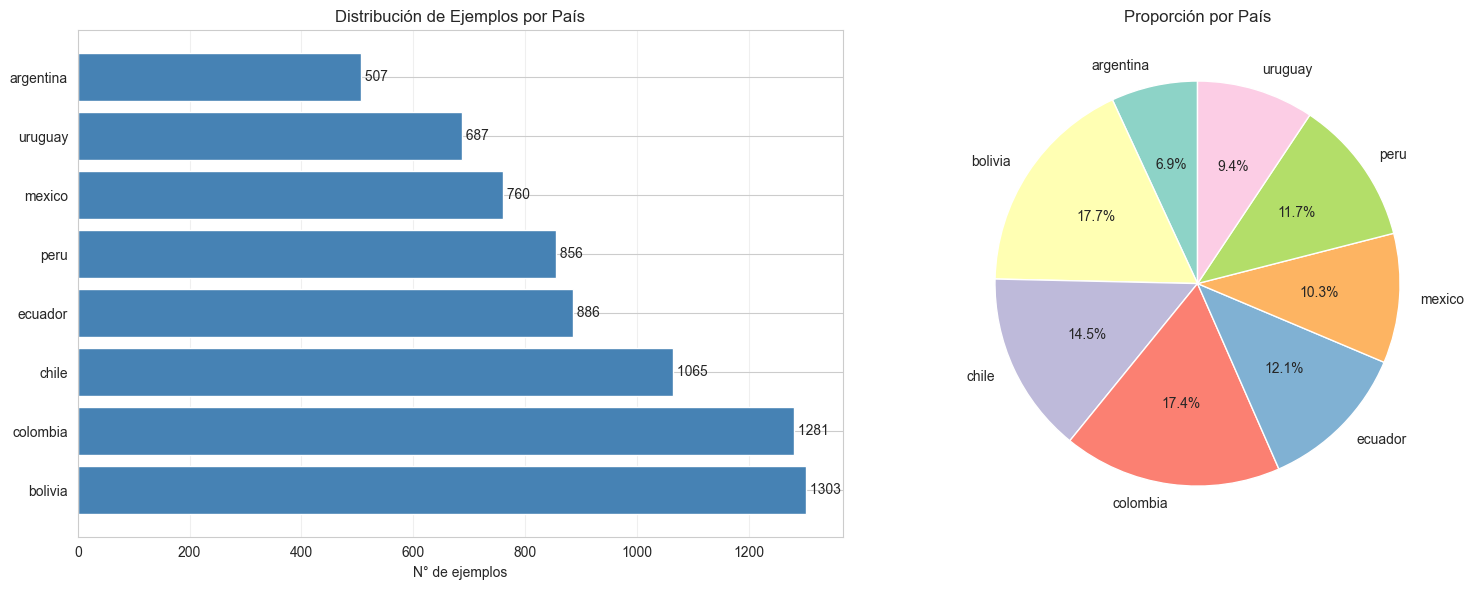


ANÁLISIS DE BALANCE
Desviación estándar: 281.3
Coeficiente de variación: 30.6%
⚠️  Dataset moderadamente desbalanceado (30% < CV < 50%)

EJEMPLOS POR PAÍS (primeros 2 de cada uno)

🌎 ARGENTINA (507 ejemplos)
  1. En argentina existe el mito de → arroyo el rey
     Subject: argentina
  2. En argentina existe el mito de → cadejo
     Subject: argentina

🌎 BOLIVIA (1303 ejemplos)
  1. En abchanchu, alimentación final es → fuerza vital del corazón
     Subject: abchanchu
  2. En abchanchu, apariencia versión 2 es → barrigón
     Subject: abchanchu

🌎 CHILE (1065 ejemplos)
  1. En alicanto, alas brillan es → según metal que coma
     Subject: alicanto
  2. En alicanto, alas brillan doradas es → si come oro
     Subject: alicanto

🌎 COLOMBIA (1281 ejemplos)
  1. En animales que anuncian, ancianos campesinos es → observan cuidadosamente comportamientos
     Subject: animales que anuncian
  2. En animales que anuncian, animales páramo es → son mensajeros presagios
     Subject: animales que a

In [31]:
"""
Análisis de distribución por país en Latinoamérica
"""

import json
from pathlib import Path
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos de Latinoamérica
latam_file = Config.PROCESSED_DIR / "latam_all.json"
with open(latam_file, 'r', encoding='utf-8') as f:
    latam_data = json.load(f)

print(f"Total ejemplos Latinoamérica: {len(latam_data)}")
print("\n" + "="*60)
print("DISTRIBUCIÓN POR PAÍS")
print("="*60 + "\n")

# Contar por país
countries = Counter()
for item in latam_data:
    # Buscar el campo que identifica el país
    country = item.get('country', item.get('region', item.get('source', 'Unknown')))
    countries[country] += 1

# Crear DataFrame para mejor visualización
df = pd.DataFrame([
    {'País': country, 'N_ejemplos': count, 'Porcentaje': f"{count/len(latam_data)*100:.1f}%"}
    for country, count in countries.most_common()
])

print(df.to_string(index=False))

# Estadísticas
print("\n" + "="*60)
print("ESTADÍSTICAS")
print("="*60)
print(f"Total países: {len(countries)}")
print(f"Promedio por país: {len(latam_data)/len(countries):.1f}")
print(f"Mediana: {sorted(countries.values())[len(countries)//2]}")
print(f"Mínimo: {min(countries.values())} ({min(countries, key=countries.get)})")
print(f"Máximo: {max(countries.values())} ({max(countries, key=countries.get)})")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de barras
countries_sorted = dict(countries.most_common())
axes[0].barh(list(countries_sorted.keys()), list(countries_sorted.values()), 
             color='steelblue')
axes[0].set_xlabel('N° de ejemplos')
axes[0].set_title('Distribución de Ejemplos por País')
axes[0].grid(axis='x', alpha=0.3)

# Agregar valores
for i, (country, count) in enumerate(countries_sorted.items()):
    axes[0].text(count, i, f' {count}', va='center')

# Gráfico de pastel
axes[1].pie(countries.values(), labels=countries.keys(), autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette('Set3', len(countries)))
axes[1].set_title('Proporción por País')

plt.tight_layout()
plt.savefig('/Users/andreaacostasolorzano/Documents/Repositorios/ProyectoIA/results/fase1//latam_distribution_by_country.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Gráfico guardado en: results/fase1/latam_distribution_by_country.png")
plt.show()

# Verificar balance
print("\n" + "="*60)
print("ANÁLISIS DE BALANCE")
print("="*60)

std_dev = pd.Series(list(countries.values())).std()
cv = std_dev / (len(latam_data)/len(countries)) * 100  # Coeficiente de variación

print(f"Desviación estándar: {std_dev:.1f}")
print(f"Coeficiente de variación: {cv:.1f}%")

if cv < 30:
    print("✅ Dataset bien balanceado (CV < 30%)")
elif cv < 50:
    print("⚠️  Dataset moderadamente desbalanceado (30% < CV < 50%)")
else:
    print("❌ Dataset muy desbalanceado (CV > 50%)")
    print("   Considera balancear en la selección de ejemplos finales")

# Mostrar ejemplos de cada país
print("\n" + "="*60)
print("EJEMPLOS POR PAÍS (primeros 2 de cada uno)")
print("="*60)

for country in countries.keys():
    country_examples = [item for item in latam_data if item.get('country', item.get('region', '')) == country]
    print(f"\n🌎 {country.upper()} ({len(country_examples)} ejemplos)")
    
    for i, example in enumerate(country_examples[:2]):
        print(f"  {i+1}. {example['prompt']} → {example['target_new']}")
        if 'subject' in example:
            print(f"     Subject: {example['subject']}")